In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Yet Another MNIST Tutorial

Data utilities - 
* **Dataset**
* **DataLoader**

Neural Network utilities - 
* **nn.Sequential**
* **nn.Module**
* **nn.Linear**
* **nn.ReLU**

Backpropagation utilites -
* **SGD**
* **CrossEntropyLoss**

Plot utilities -
* **matplotlib `plt.subplots`**


In [2]:
from torchvision import datasets

fmnist = datasets.FashionMNIST('~/data/FMNIST', download=True)
tr_images = fmnist.data.float()
tr_targets = fmnist.targets
unique_values = tr_targets.unique()

fmnist = datasets.FashionMNIST('~/data/FMNIST', download=True, train=False)
val_images = fmnist.data.float()
val_targets = fmnist.targets

print(f'Train:\n\tX - {tr_images.shape}\n\tY - {tr_targets.shape}\n\tY - Unique Values : {unique_values}')
print(f'Val:\n\tX - {val_images.shape}\n\tY - {val_targets.shape}\n\tY - Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

Train:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Val:
	X - torch.Size([10000, 28, 28])
	Y - torch.Size([10000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Data

`torch.utils.data.Dataset`  

An object that can do two things
* Return how many data points are there?
* Return i$^{th}$ x, y of data

Below we create two `Dataset` objects one for train, one for test

```python

train = TensorDataset(images, targets)
x, y = train[0]
assert x.shape == torch.Size([28, 28])
assert y.shape == torch.Size([]) # it's a scalar
>>> len(train) == len(images)
True
```


In [3]:
from torch.utils.data import TensorDataset, DataLoader, Dataset

class FMNISTDataset(Dataset):
    def __init__(self, x, y): self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix]/255., self.y[ix]
        x = x.view(28*28)
        return x.to(device), y.to(device)
    def __len__(self): return len(self.x)
    
train = FMNISTDataset(tr_images, tr_targets)
val = FMNISTDataset(val_images, val_targets)
    
print(f'Train:\t{len(train)} images\nVal:\t{len(val)} images')

trn_dl = DataLoader(train, batch_size=32, shuffle=True)
val_dl = DataLoader(val, batch_size=32, shuffle=False)

Train:	60000 images
Val:	10000 images


#### Inspect
Visually inspect the data.

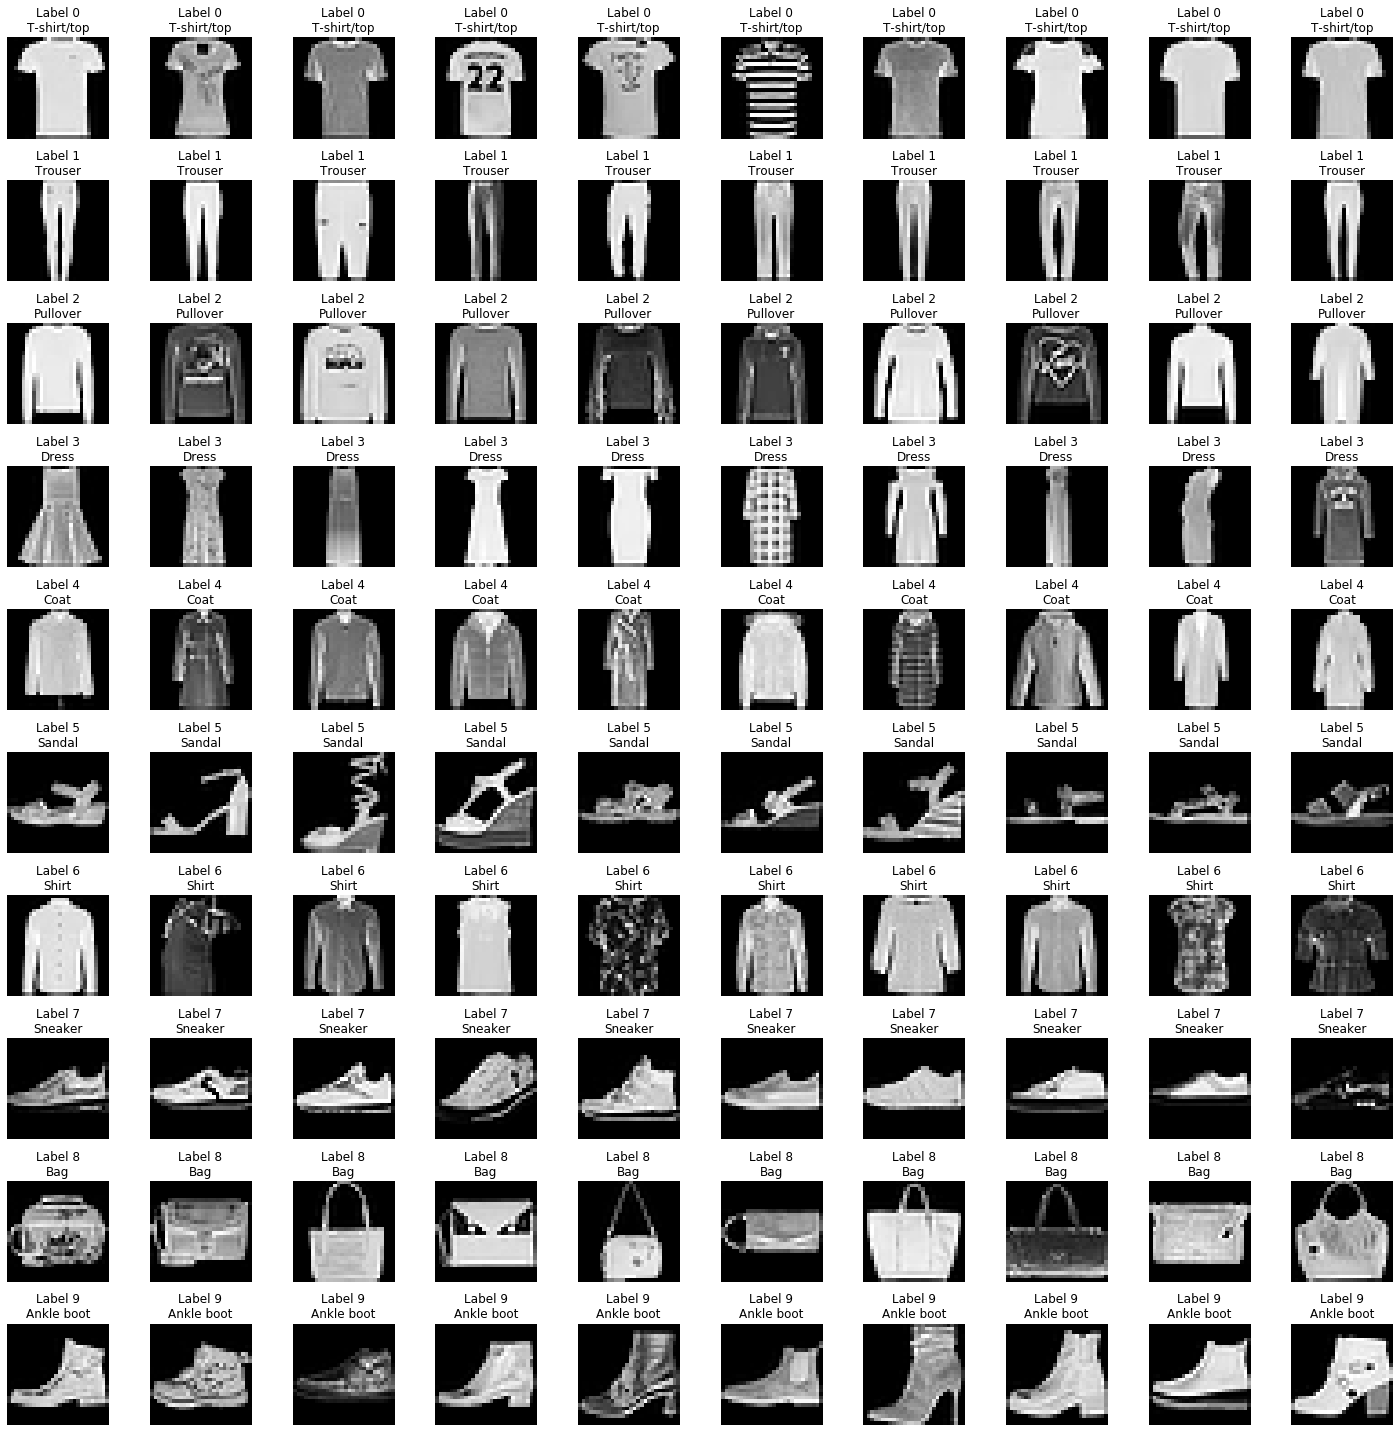

In [4]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(20,20))

for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
        plot_cell.set_title(f'Label {y}\n{fmnist.classes[y]}')
plt.tight_layout()

#### Create DataLoader

Object: `torch.utils.data.DataLoder`  
It collates all data from the `dataset` object and, wraps it in such a way that it returns a _batch_ of data whenever we ask for it.

Sampling is an integral part of deep learning.  
The most common sampling we see is the *load n data-points* batchwise due to compuational issues.  
It is easier to load a mini-batch of data, train on it and load a fresh smaller batch and continue training.  
<small>This is because the matrix multiplications on a single forward-backward pass demand a lot of computation as well as memory **simultaneously**</small>


In [5]:
from torch.utils.data import DataLoader

trn_dl = DataLoader(train, batch_size=256, shuffle=True)

epoch = iter(trn_dl)

for _ in range(3):
    batch = next(epoch)
    x, y = batch
    print(x.shape, y.shape)

torch.Size([256, 784]) torch.Size([256])
torch.Size([256, 784]) torch.Size([256])
torch.Size([256, 784]) torch.Size([256])


`>>> print(len(trn_dl)) `  
1875


i.e., the number of batches in the epoch, 
in the above code we called next only 3 times. 
We could've called it upto 1875 times each time getting a different batch of images. 
At the end of these 1875 calls, 
we would have used all our train images exactly once for training, and  this will automatically end *one epoch* of data.


##### Summary
`torch.utils.data.dataset` -   
An abstract object that needs two things for creating it:
    1. What is it's length (i.e., __len__)
    2. What it should return on calling the i$^{th}$ index

`torch.utils.data.DataLoader` -   
An object that takes a `dataset` and `batch_size` as input and returns a batch of data everytime we call `__next__` on it

### Model

Let's start with a simple fully connected neural network with one hidden layer

In [6]:
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import SGD
# from torch.optim.lr_scheduler import ReduceLROnPlateau

def _model(): 
    return nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)).to(device)

#### Train

In [7]:
def train_batch(x, y, model, opt, loss_fn):
    'call your model like any python function on your batch of inputs'
    prediction = model(x)
    'compute loss'
    batch_loss = loss_fn(prediction, y)
    'based on the forward pass in `model(x)` compute all the gradients of `model.parameters()`'
    batch_loss.backward()
    'apply new-weights = f(old-weights, old-weight-gradients) where "f" is the optimizer.'
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def validate_batch(x, y, model, loss_fn):
    'just do a forward pass and store the losses for the entire batch'
    prediction = model(x)
    'compute if the location of maximum in each row coincides with ground truth'
    is_correct = prediction.max(-1)[1] == y
    batch_loss = loss_fn(prediction, y)
    return batch_loss.item(), is_correct

In [12]:
from tensorboardX import SummaryWriter
import datetime, time
def now(): return f'{datetime.datetime.now():%H:%M_%d-%m}'

def fit(model, n_epochs=15):
    trn_dl = DataLoader(train, batch_size=64, shuffle=True)
    val_dl = DataLoader(val, batch_size=64)
    optimizer = SGD(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    best_val_acc = []
    for epoch in range(n_epochs):
        train_losses = []
        val_losses = []
        val_acc = []
        start = time.time()
        N_trn = len(trn_dl)
        for ix, batch in enumerate(iter(trn_dl)):
            x, y = batch
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_losses.append(batch_loss)
            print(f'{ix}/{N_trn}, Loss: {batch_loss:.3f}', end='\r') # logging

        # Validate
        N_val = len(val_dl)
        for ix, batch in enumerate(iter(val_dl)):
            print(f'Testing {ix}/{N_val}', end='\r') # logging
            x, y = batch
            batch_loss, corrects = validate_batch(x, y, model, loss_fn)
            val_losses.append(batch_loss)
            val_acc.extend(corrects.tolist())

        print(f'Epoch: {epoch+1:3d}, Train Loss: {np.mean(train_losses):.3f}, Validation Loss: {np.mean(val_losses):.3f}, Validation Acc: {np.mean(val_acc )*100:.2f}% Time: {time.time()-start:.0f} seconds')
        # scheduler.step()
    return model

In [13]:
model = fit(_model(), n_epochs=10)


Epoch:   1, Train Loss: 1.959, Validation Loss: 1.667, Validation Acc: 64.87% Time: 4 seconds
Epoch:   2, Train Loss: 1.441, Validation Loss: 1.269, Validation Acc: 65.96% Time: 4 seconds
Epoch:   3, Train Loss: 1.147, Validation Loss: 1.065, Validation Acc: 67.23% Time: 4 seconds
Epoch:   4, Train Loss: 0.993, Validation Loss: 0.951, Validation Acc: 68.13% Time: 4 seconds
Epoch:   5, Train Loss: 0.901, Validation Loss: 0.880, Validation Acc: 70.58% Time: 4 seconds
Epoch:   6, Train Loss: 0.840, Validation Loss: 0.829, Validation Acc: 72.25% Time: 5 seconds
Epoch:   7, Train Loss: 0.795, Validation Loss: 0.791, Validation Acc: 73.17% Time: 4 seconds
Epoch:   8, Train Loss: 0.760, Validation Loss: 0.760, Validation Acc: 74.07% Time: 4 seconds
Epoch:   9, Train Loss: 0.732, Validation Loss: 0.735, Validation Acc: 75.18% Time: 4 seconds
Epoch:  10, Train Loss: 0.708, Validation Loss: 0.713, Validation Acc: 75.59% Time: 4 seconds


#### Inspect Predictions

#####  Random

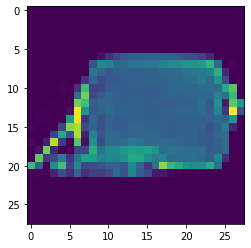

In [24]:
plt.imshow()

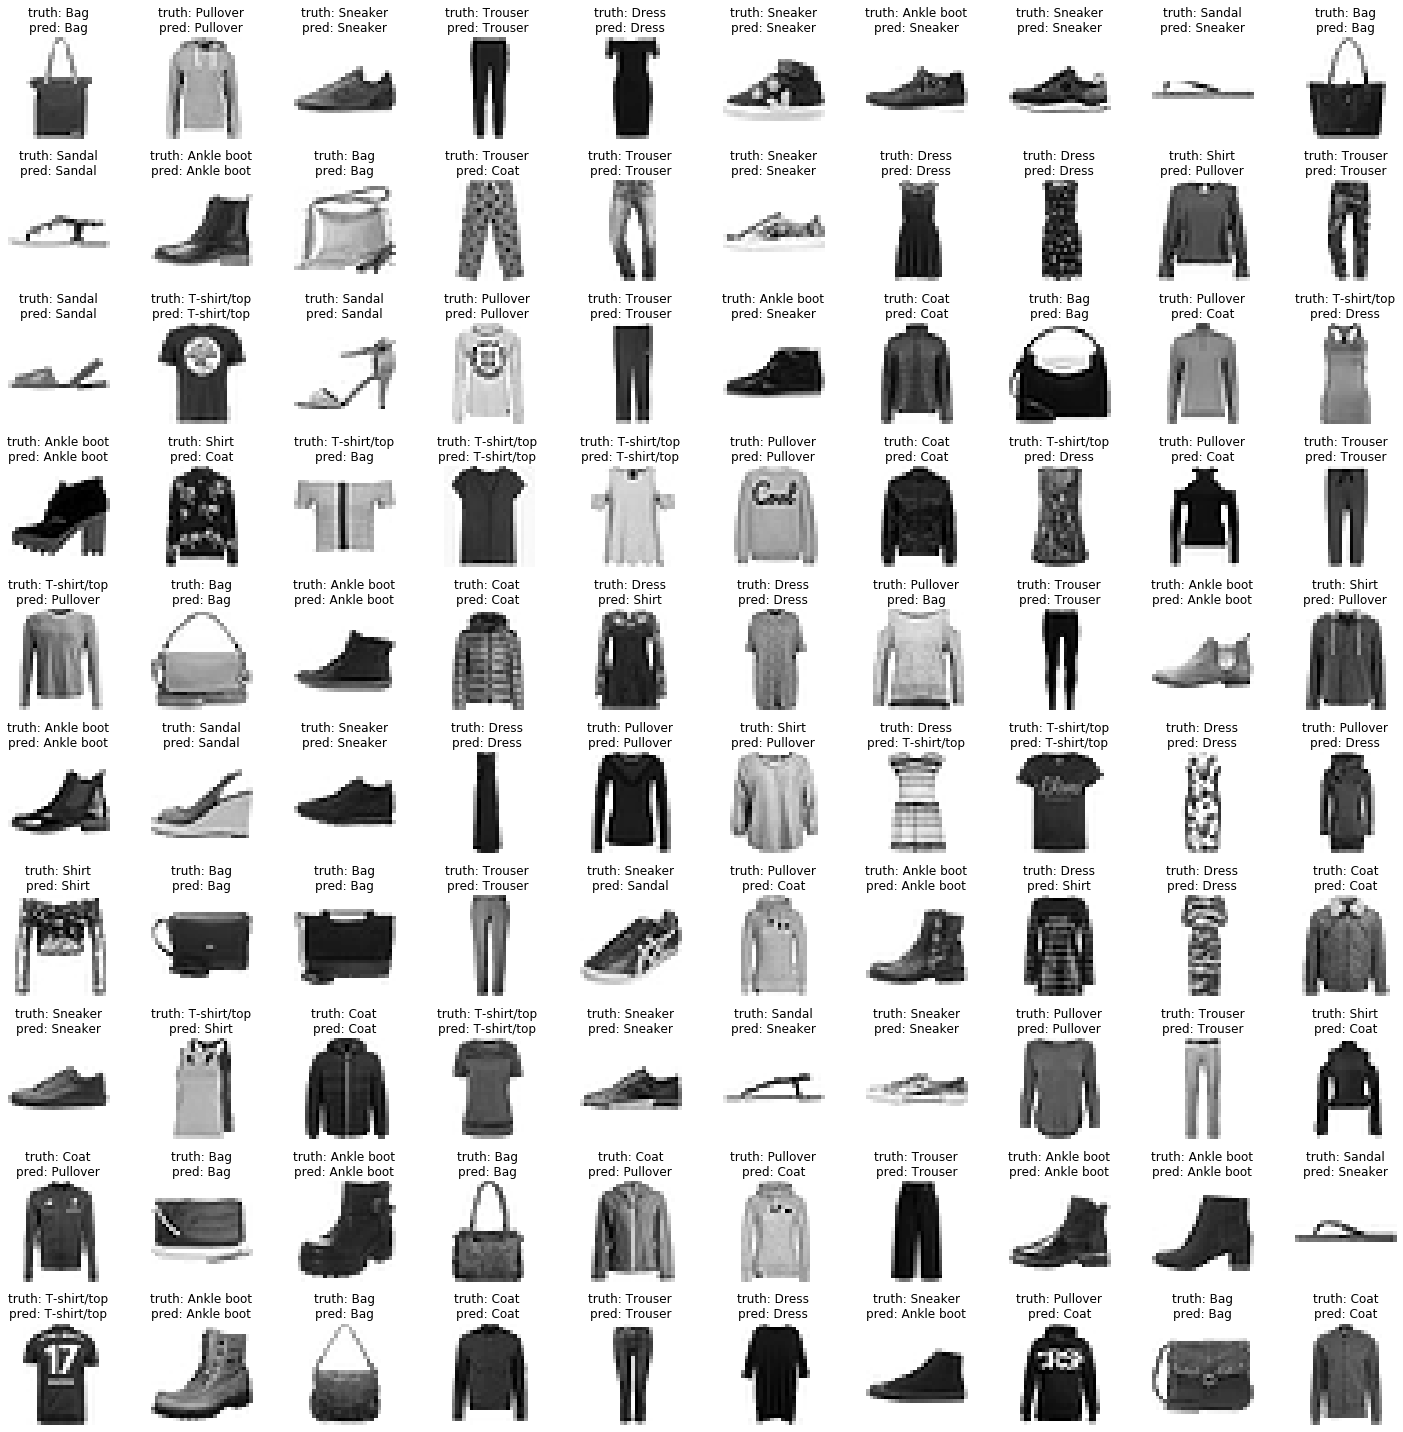

In [28]:
# %%time
R, C = 10,10
fig, ax = plt.subplots(R, C, figsize=(20,20))

for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(len(val_images))
        x, y = val[ix]
        
        pred = model(x.view(1, -1).to(device))
        _, pred = pred.max(-1)
        
        plot_cell.imshow(255*x.view(28, 28).to('cpu'), cmap='gray_r')
        plot_cell.set_title(f'truth: {fmnist.classes[y]}\npred: {fmnist.classes[pred.cpu().item()]}')
plt.tight_layout()